<a href="https://colab.research.google.com/github/camilawiesner1/Parcial-Final-HE2-Inteligencia-Artificial/blob/main/App_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Paso 1: cargar los datos y el modelo de Gemini para procesar y etiquetar tweets**

Vamos a cargar los tweets para procesar con Gemini (y así crear un dataset de entrenamiento para el modelo).

***Fuente:***  Preda, G. (2020). Trump Tweets: Preliminary EDA [Conjunto de datos]. Kaggle. Recuperado de https://www.kaggle.com/code/gpreda/trump-tweets-preliminary-eda/input

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from google.colab import files
uploaded = files.upload()

Saving trump_tweets.csv to trump_tweets.csv


In [ ]:
df = pd.read_csv('trump_tweets.csv')
print(df.head())

                    id        user_name   user_location  \
0  1285299379746811915  Donald J. Trump  Washington, DC   
1  1285196013020610562  Donald J. Trump  Washington, DC   
2  1284899438591451137  Donald J. Trump  Washington, DC   
3  1284894845614600194  Donald J. Trump  Washington, DC   
4  1288503660264058880  Donald J. Trump  Washington, DC   

                                   user_description         user_created  \
0  45th President of the United States of America🇺🇸  2009-03-18 13:46:38   
1  45th President of the United States of America🇺🇸  2009-03-18 13:46:38   
2  45th President of the United States of America🇺🇸  2009-03-18 13:46:38   
3  45th President of the United States of America🇺🇸  2009-03-18 13:46:38   
4  45th President of the United States of America🇺🇸  2009-03-18 13:46:38   

   user_followers  user_friends  user_favourites  user_verified  \
0        84262854            50                4           True   
1        84262854            50                4      

In [ ]:
# Seleccionar aleatoriamente 400 observaciones
df_400 = df.sample(n=400, random_state=42)  # 'random_state' para reproducibilidad

# Mostrar las primeras filas del nuevo DataFrame
print(df_400.head())

# Exportar a un archivo Excel
df_400.to_excel("df_400.xlsx", index=False)

                       id        user_name   user_location  \
582   1313551795646541824  Donald J. Trump  Washington, DC   
1851  1340386251866828802  Donald J. Trump  Washington, DC   
1052  1321241518422675457  Donald J. Trump  Washington, DC   
1075  1321078919924207617  Donald J. Trump  Washington, DC   
917   1319232315265077251  Donald J. Trump  Washington, DC   

                                      user_description         user_created  \
582   45th President of the United States of America🇺🇸  2009-03-18 13:46:38   
1851  45th President of the United States of America🇺🇸  2009-03-18 13:46:38   
1052  45th President of the United States of America🇺🇸  2009-03-18 13:46:38   
1075  45th President of the United States of America🇺🇸  2009-03-18 13:46:38   
917   45th President of the United States of America🇺🇸  2009-03-18 13:46:38   

      user_followers  user_friends  user_favourites  user_verified  \
582         87256505            50                5           True   
1851        

Vamos a categorizar los tweets de acuerdo a su contenido:

*   **Proteccionista** (políticas arancelarias o relacionadas con el comercio exterior o que eviten la importación de bs. y ss.)
*   **Anti-migratiorio** (deportación de migrantes indocumentados).
*   **Pro-empresa** (políticas que, de la mano con el proteccionismo, fomenten la producción y el consumo nacional. Un ejemplo son las reducciones de impuestos de renta a empresas, subsidios, etc.



In [ ]:
#Instalar los paquetes necesarios para el entrenamiento del modelo
!pip install fsspec==2024.10.0
!pip install gcsfs==2024.10.0 fsspec==2024.10.0
!pip install transformers datasets -q # Instalar paquetes transformers y datasets
!pip install transformers[torch] -q  # Instalar transformers con soporte para PyTorch
!pip install accelerate -q # Instalar accelerate
!pip install evaluate -q  # Instalar evaluate



  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.10.0-py3-none-any.whl (179 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
      Successfully uninstalled fsspec-2024.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.1.0 requires fsspec[http]<=2024.9.0,>=2023.1.0, but you have fsspec 2024.10.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
from datasets import load_dataset, Dataset  # Importar Dataset de datasets
from transformers import AutoTokenizer  # Importar AutoTokenizer de transformers
from transformers import AutoModelForSequenceClassification  # Importar AutoModelForSequenceClassification de transformers
from transformers import TrainingArguments, Trainer  # Importar TrainingArguments y Trainer de transformers
import numpy as np  # Importar numpy
import evaluate  # Importar evaluate
import time


In [ ]:
pip install -q -U google-generativeai

In [ ]:
## Para importar Gemini
# Import the Python SDK
import google.generativeai as genai
# Used to securely store your API key
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

SecretNotFoundError: Secret GOOGLE_API_KEY does not exist.

In [ ]:
# Gemini-1.5-8b
## Puede consultar la documentación a continuación: https://ai.google.dev/gemini-api/docs/models/gemini?hl=es-419
model = genai.GenerativeModel("gemini-1.5-flash-8b")


In [ ]:
import re

# Función para clasificar tweets utilizando el modelo Gemini-1.5-8b
def clasificar_tweet(text):
    # Define el prompt para la clasificación
    prompt = f"""
    Quiero que leas el contenido de un texto y determines su categoría basándote en las siguientes definiciones:

    1. Proteccionista: Tweets relacionados con políticas arancelarias, comercio exterior o medidas para evitar la importación de bienes y servicios.
    2. Anti-migratorio: Tweets relacionados con la deportación de migrantes indocumentados o políticas anti-inmigrantes.
    3. Pro-empresa: Tweets relacionados con políticas que fomenten la producción y el consumo nacional, como reducciones de impuestos a empresas, subsidios o apoyo a las industrias locales.

    Lee el siguiente texto y responde con una de las tres categorías mencionadas, o indica 'Sin categoría' si no se ajusta a ninguna.

    Texto: {text}

    Clasificación:
    """

    # Genera la respuesta con el modelo
    response = model.generate_content(prompt)

    # Extrae solo la categoría utilizando una expresión regular
    categorias_posibles = ['Proteccionista', 'Anti-migratorio', 'Pro-empresa', 'Sin categoría']

    # Busca la categoría en la respuesta, si no se encuentra, asigna 'Sin categoría'
    for categoria in categorias_posibles:
        if categoria.lower() in response.text.lower():
            return categoria

    return 'Sin categoría'  # Si no se encuentra ninguna categoría

# Función para procesar los tweets en lotes de 14 y esperar 60 segundos entre cada solicitud
def procesar_en_lotes(df_400, batch_size=14, espera=63):
    categorias = []  # Lista para almacenar las categorías resultantes
    for i in range(0, len(df_400), batch_size):
        # Selecciona el lote de tweets
        batch = df_400.iloc[i:i+batch_size]

        # Aplica la función de clasificación a los tweets del lote
        batch['categoria'] = batch['text'].apply(clasificar_tweet)

        # Agrega las categorías al resultado general
        categorias.extend(batch['categoria'].tolist())

        # Espera el tiempo indicado antes de procesar el siguiente lote
        print(f"Procesando el lote {i // batch_size + 1} de {len(df_400) // batch_size + 1}...")
        time.sleep(espera)  # Espera 60 segundos entre solicitudes

    # Retorna las categorías clasificadas
    return categorias

# Aplica la función de lotes a df_400
df_400['categoria'] = procesar_en_lotes(df_400)

# Muestra los resultados con las clasificaciones
print(df_400[['text', 'categoria']])

ReadTimeout: HTTPConnectionPool(host='localhost', port=33307): Read timed out. (read timeout=600.0)

Sabemos que funciona porque estos son algunos de sus análisis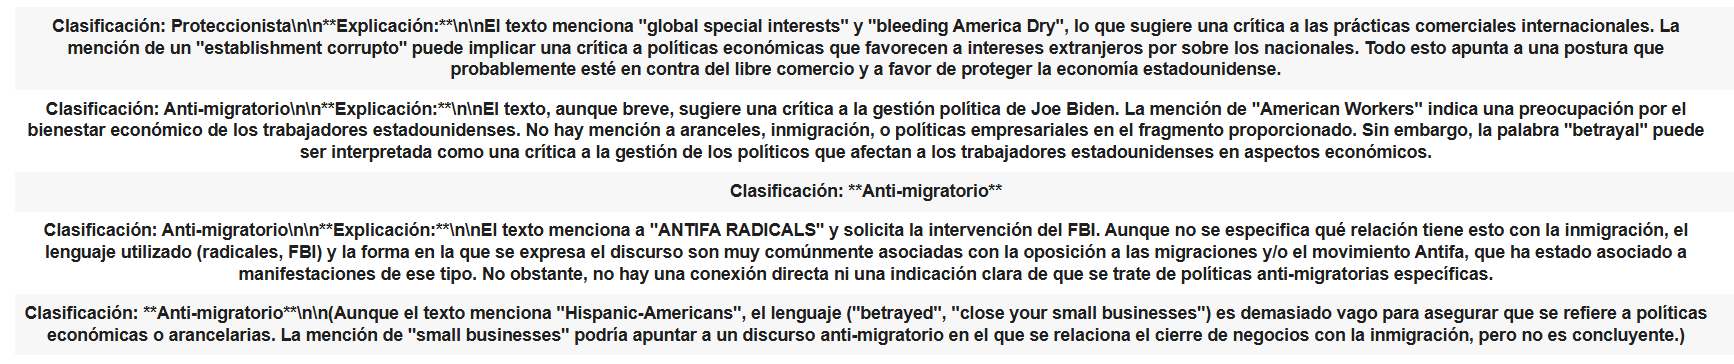

In [ ]:
# Seleccionamos las columnas que nos sirven
df_clean = df_400[['id', 'date', 'text', 'hashtags', 'categoria' ]]

# Muestra las primeras filas para verificar
print(df_clean.head())

# Exportar a un archivo Excel
df_clean.to_excel("df_clean.xlsx", index=False)

In [ ]:
df_clean['categoria'].value_counts()

,count
categoria,
Sin categoría,381
Pro-empresa,10
Anti-migratorio,5
Proteccionista,4


**2. Fine Tuning**
Ahora debemos fine tunear un modelo para posteriormente entrenarlo